In [1]:
!git clone https://github.com/FaridRash/Brain-tumor-multimodal-image-CT-MRI-

Cloning into 'Brain-tumor-multimodal-image-CT-MRI-'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 56 (delta 11), reused 44 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 19.93 MiB | 40.33 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0ZNEkMlo0McwJDUVdxYQ")
project = rf.workspace("joshua-zgc7b").project("ct-brain-segmentation")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-s


Extracting Dataset Version Zip to CT-Brain-Segmentation-1 in yolov8:: 100%|██████████| 21728/21728 [00:03<00:00, 7233.46it/s] 


In [3]:
# Dataset sanity-check + summary (run this cell as-is)
from pathlib import Path
from collections import Counter
import yaml

DATASET_ROOT = Path("/kaggle/working/CT-Brain-Segmentation-1")

# 1) Read data.yaml
data_yaml = DATASET_ROOT / "data.yaml"
with open(data_yaml, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

print("== data.yaml ==")
print(f"nc: {cfg.get('nc')}")
print(f"names: {cfg.get('names')}")
print(f"train: {cfg.get('train')}")
print(f"val:   {cfg.get('val')}")
print(f"test:  {cfg.get('test')}")

# 2) Count files per split
print("\n== split counts ==")
for split in ["train", "valid", "test"]:
    img_dir = DATASET_ROOT / split / "images"
    lbl_dir = DATASET_ROOT / split / "labels"
    img_count = len(list(img_dir.glob("*")))
    lbl_count = len(list(lbl_dir.glob("*.txt")))
    print(f"{split}: images={img_count}, labels={lbl_count}")

# 3) Count annotation rows per class id
class_counts = Counter()
label_files = list((DATASET_ROOT / "train" / "labels").glob("*.txt")) \
            + list((DATASET_ROOT / "valid" / "labels").glob("*.txt")) \
            + list((DATASET_ROOT / "test" / "labels").glob("*.txt"))

for lf in label_files:
    with open(lf, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            cls_id = line.split()[0]
            class_counts[cls_id] += 1

print("\n== annotation rows by class id ==")
for k in sorted(class_counts.keys(), key=int):
    print(f"class_{k}: {class_counts[k]}")
print(f"total annotation rows: {sum(class_counts.values())}")


== data.yaml ==
nc: 2
names: ['0', '1']
train: ../train/images
val:   ../valid/images
test:  ../test/images

== split counts ==
train: images=9395, labels=9395
valid: images=738, labels=738
test: images=725, labels=725

== annotation rows by class id ==
class_0: 4547
class_1: 6389
total annotation rows: 10936


In [5]:
!pip install ultralytics

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [7]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [7]:
from ultralytics import YOLO

data_yaml = "/kaggle/working/CT-Brain-Segmentation-1/data.yaml"
model = YOLO("yolov8n-seg.pt")

model.train(
    data=data_yaml,
    epochs=50,
    imgsz=640,
    batch=16,          
    device=0,         # force GPU
    workers=2,
    project="runs_brain_ct",
    name="yolov8n_seg_baseline"
)


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/CT-Brain-Segmentation-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8n_seg_baseline2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79bff65834a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [13]:
from ultralytics import YOLO

model = YOLO("runs/segment/runs_brain_ct/yolov8n_seg_baseline2/weights/best.pt")
metrics = model.val()

print(metrics)


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
YOLOv8n-seg summary (fused): 86 layers, 3,258,454 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 885.9±269.5 MB/s, size: 50.4 KB)
val: Scanning /kaggle/working/CT-Brain-Segmentation-1/valid/labels.cache... 738 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 738/738 238.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 47/47 4.8it/s 9.7s0.2s
                   all        738        744      0.995      0.992      0.995      0.986      0.995      0.992      0.995      0.986
                     1        738        744      0.995      0.992      0.995      0.986      0.995      0.992      0.995      0.986
Speed: 1.4ms preprocess, 5.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/runs/segment/val
ultralytics.utils.m

In [14]:
from ultralytics import YOLO

model = YOLO("runs/segment/runs_brain_ct/yolov8n_seg_baseline2/weights/best.pt")

metrics = model.val()

print("Box mAP50:", metrics.box.map50)
print("Box mAP50-95:", metrics.box.map)

print("Mask mAP50:", metrics.seg.map50)
print("Mask mAP50-95:", metrics.seg.map)

print("Precision:", metrics.seg.mp)
print("Recall:", metrics.seg.mr)


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
YOLOv8n-seg summary (fused): 86 layers, 3,258,454 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 707.4±288.1 MB/s, size: 53.9 KB)
val: Scanning /kaggle/working/CT-Brain-Segmentation-1/valid/labels.cache... 738 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 738/738 281.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 47/47 4.8it/s 9.8s0.2s
                   all        738        744      0.995      0.992      0.995      0.986      0.995      0.992      0.995      0.986
                     1        738        744      0.995      0.992      0.995      0.986      0.995      0.992      0.995      0.986
Speed: 1.4ms preprocess, 5.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/runs/segment/val2
Box mAP50: 0.99493

In [18]:
model.predict(
    source="/kaggle/working/CT-Brain-Segmentation-1/valid/images",
    save=True,
    conf=0.25
)



image 1/738 /kaggle/working/CT-Brain-Segmentation-1/valid/images/SEVERIANO-TAMANI-JUAN-9-0001_BMP_jpg.rf.3ad300149e3b007a0adebee9953b62cc.jpg: 640x640 1 1, 9.5ms
image 2/738 /kaggle/working/CT-Brain-Segmentation-1/valid/images/SEVERIANO-TAMANI-JUAN-9-0001_BMP_jpg.rf.48ae7169e1830973fb3b002a1d513e99.jpg: 640x640 1 1, 9.2ms
image 3/738 /kaggle/working/CT-Brain-Segmentation-1/valid/images/SEVERIANO-TAMANI-JUAN-9-0001_BMP_jpg.rf.ec304edd3c0f547a99a3510240f30b5a.jpg: 640x640 1 1, 9.2ms
image 4/738 /kaggle/working/CT-Brain-Segmentation-1/valid/images/SHAPIAMA-DAVILA0002_jpg.rf.064e14de637245d9773d194b0838c475.jpg: 640x640 2 1s, 9.2ms
image 5/738 /kaggle/working/CT-Brain-Segmentation-1/valid/images/SHAPIAMA-DAVILA0002_jpg.rf.93ec6ad840cc7610e135ea3923bd3aa0.jpg: 640x640 2 1s, 9.2ms
image 6/738 /kaggle/working/CT-Brain-Segmentation-1/valid/images/SHAPIAMA-DAVILA0002_jpg.rf.ca059839b17750a9296688d8809fbc62.jpg: 640x640 2 1s, 9.2ms
image 7/738 /kaggle/working/CT-Brain-Segmentation-1/valid/image

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: '0', 1: '1'}
 obb: None
 orig_img: array([[[14, 14, 14],
         [ 0,  0,  0],
         [ 9,  9,  9],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 2,  2,  2],
         [ 0,  0,  0],
         [ 5,  5,  5],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[14, 14, 14],
         [ 3,  3,  3],
         [14, 14, 14],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  

In [19]:
!ls CT-Brain-Segmentation-1/train/images | wc -l
!ls CT-Brain-Segmentation-1/valid/images | wc -l
!ls CT-Brain-Segmentation-1/test/images | wc -l


9395
738
725


In [20]:
import os

train_files = os.listdir("CT-Brain-Segmentation-1/train/images")
valid_files = os.listdir("CT-Brain-Segmentation-1/valid/images")

print(train_files[:10])
print(valid_files[:10])


['AMARINGO-MONTES0005_jpg.rf.d77bd980a7c8cab85a786de9ce1cd394.jpg', 'CAINA-VILLACREZ0004_jpg.rf.bc00274f6c41c240b8e9bf9464797af9.jpg', 'nor220_jpg.rf.2c20d52a397586c19c564472f9a1500c.jpg', 'nor557_jpg.rf.b9a1a2c8fd7b6c93917a73021bc36fe7.jpg', 'nor269_jpg.rf.35ec8385537bc5ad67f4b1404913f99f.jpg', 'nor576_jpg.rf.30201329fc7b46e5757ca8f2aebfd9f7.jpg', 'CUADROS-CORTILO0003_jpg.rf.b97631a055e90ce379d2f6fb1d2e9d8b.jpg', 'nava2_jpg.rf.d876ac9abe1c4573d2acd835d7967bed.jpg', 'lis2_jpg.rf.b93216c1e383a821962496120f9a90dd.jpg', 'HUINAPI-RIOS0002_jpg.rf.f6ec1fbe0d640ecd1573ecc8cd95881b.jpg']
['ZARATE-FLORES0001_jpg.rf.8e6dfa746de61a7e08c4569470fe7622.jpg', 'sopli2_jpg.rf.471b85dc753ffebc737029991a5df3af.jpg', 'TAULLIMA-CAMPOS0002_jpg.rf.a1ba4ba08cfda6328e7777d4f999c3ab.jpg', 'TAMANI-AHUANARI-4-S0-I35_JPG_jpg.rf.69362e75cd6f2109a9c6951d65407c1c.jpg', 'VELA-TAPULLIMA0004_jpg.rf.bcc31f3d1b33ddb5adea7a49bd48863b.jpg', 'yara5_jpg.rf.63a3ec4e90658b3499184e62d47464b3.jpg', 'VASQUEZ-IMAYA0001_jpg.rf.3ea2a

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

results_path = "runs/segment/runs_brain_ct/yolov8n_seg_baseline2/results.csv"
df = pd.read_csv(results_path)

df.columns = df.columns.str.strip()
print(df.columns)


Index(['epoch', 'time', 'train/box_loss', 'train/seg_loss', 'train/cls_loss',
       'train/dfl_loss', 'train/sem_loss', 'metrics/precision(B)',
       'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)',
       'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)',
       'metrics/mAP50-95(M)', 'val/box_loss', 'val/seg_loss', 'val/cls_loss',
       'val/dfl_loss', 'val/sem_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


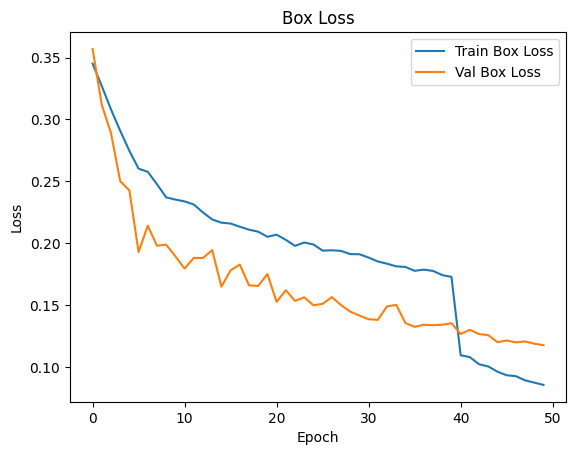

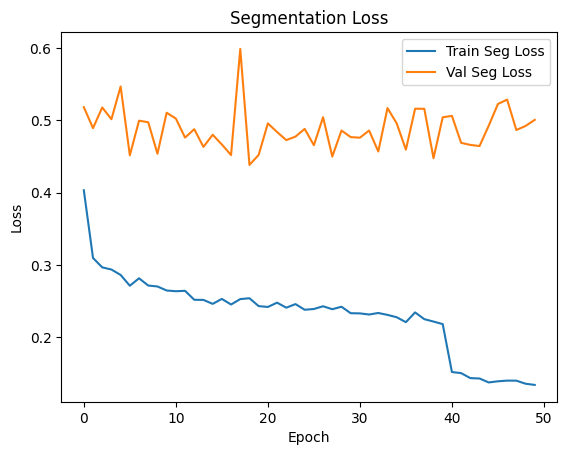

In [22]:
plt.figure()
plt.plot(df['train/box_loss'], label='Train Box Loss')
plt.plot(df['val/box_loss'], label='Val Box Loss')
plt.legend()
plt.title("Box Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(df['train/seg_loss'], label='Train Seg Loss')
plt.plot(df['val/seg_loss'], label='Val Seg Loss')
plt.legend()
plt.title("Segmentation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


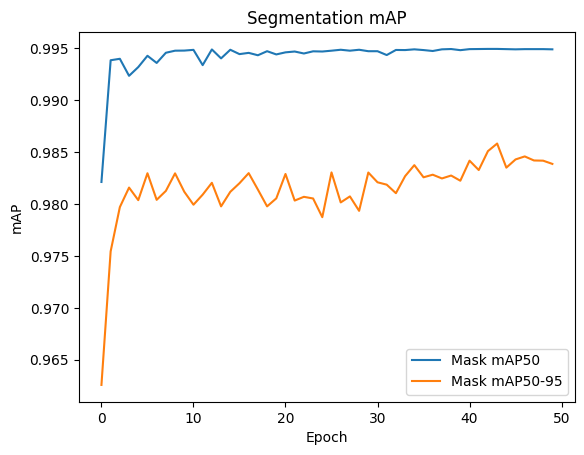

In [23]:
plt.figure()
plt.plot(df['metrics/mAP50(M)'], label='Mask mAP50')
plt.plot(df['metrics/mAP50-95(M)'], label='Mask mAP50-95')
plt.legend()
plt.title("Segmentation mAP")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.show()


In [24]:
from ultralytics import YOLO

model = YOLO("runs/segment/runs_brain_ct/yolov8n_seg_baseline2/weights/best.pt")

metrics = model.val(
    save=True,
    plots=True
)


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
YOLOv8n-seg summary (fused): 86 layers, 3,258,454 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 846.4±248.2 MB/s, size: 60.2 KB)
val: Scanning /kaggle/working/CT-Brain-Segmentation-1/valid/labels.cache... 738 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 738/738 123.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 47/47 5.0it/s 9.5s0.2s
                   all        738        744      0.995      0.992      0.995      0.986      0.995      0.992      0.995      0.986
                     1        738        744      0.995      0.992      0.995      0.986      0.995      0.992      0.995      0.986
Speed: 1.3ms preprocess, 5.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/runs/segment/val3


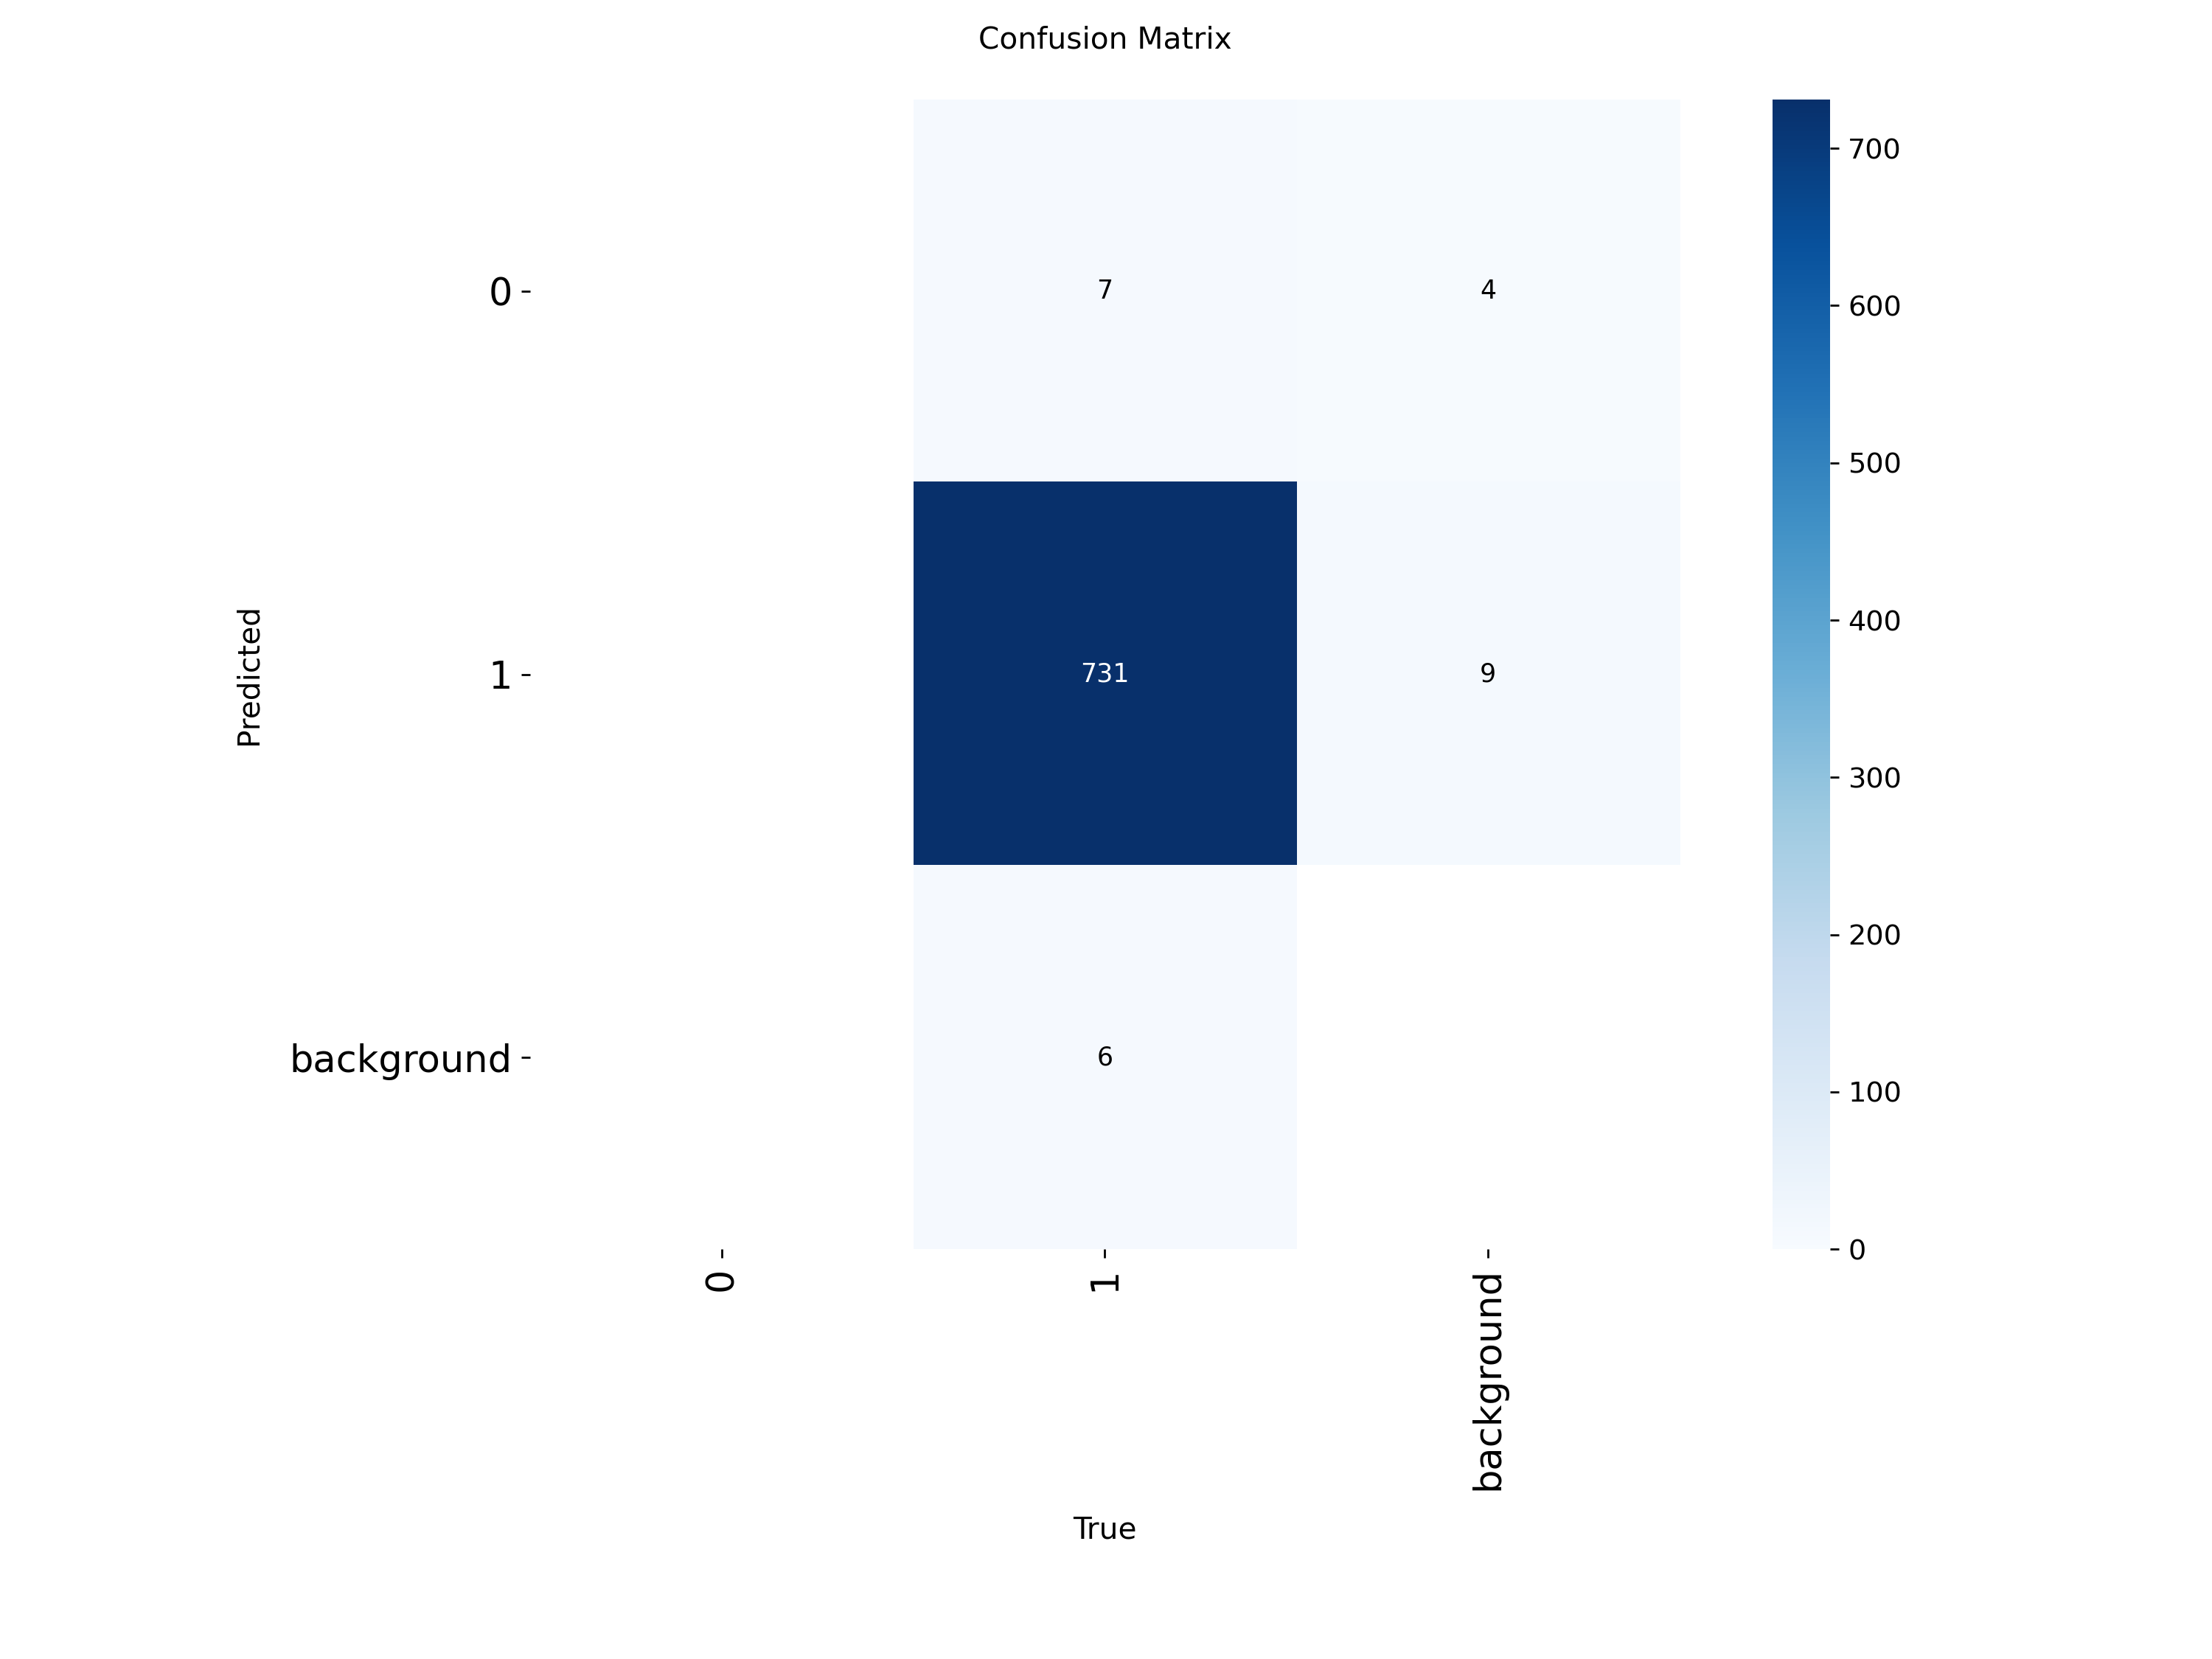

In [28]:
from IPython.display import Image
Image("runs/segment/val2/confusion_matrix.png")




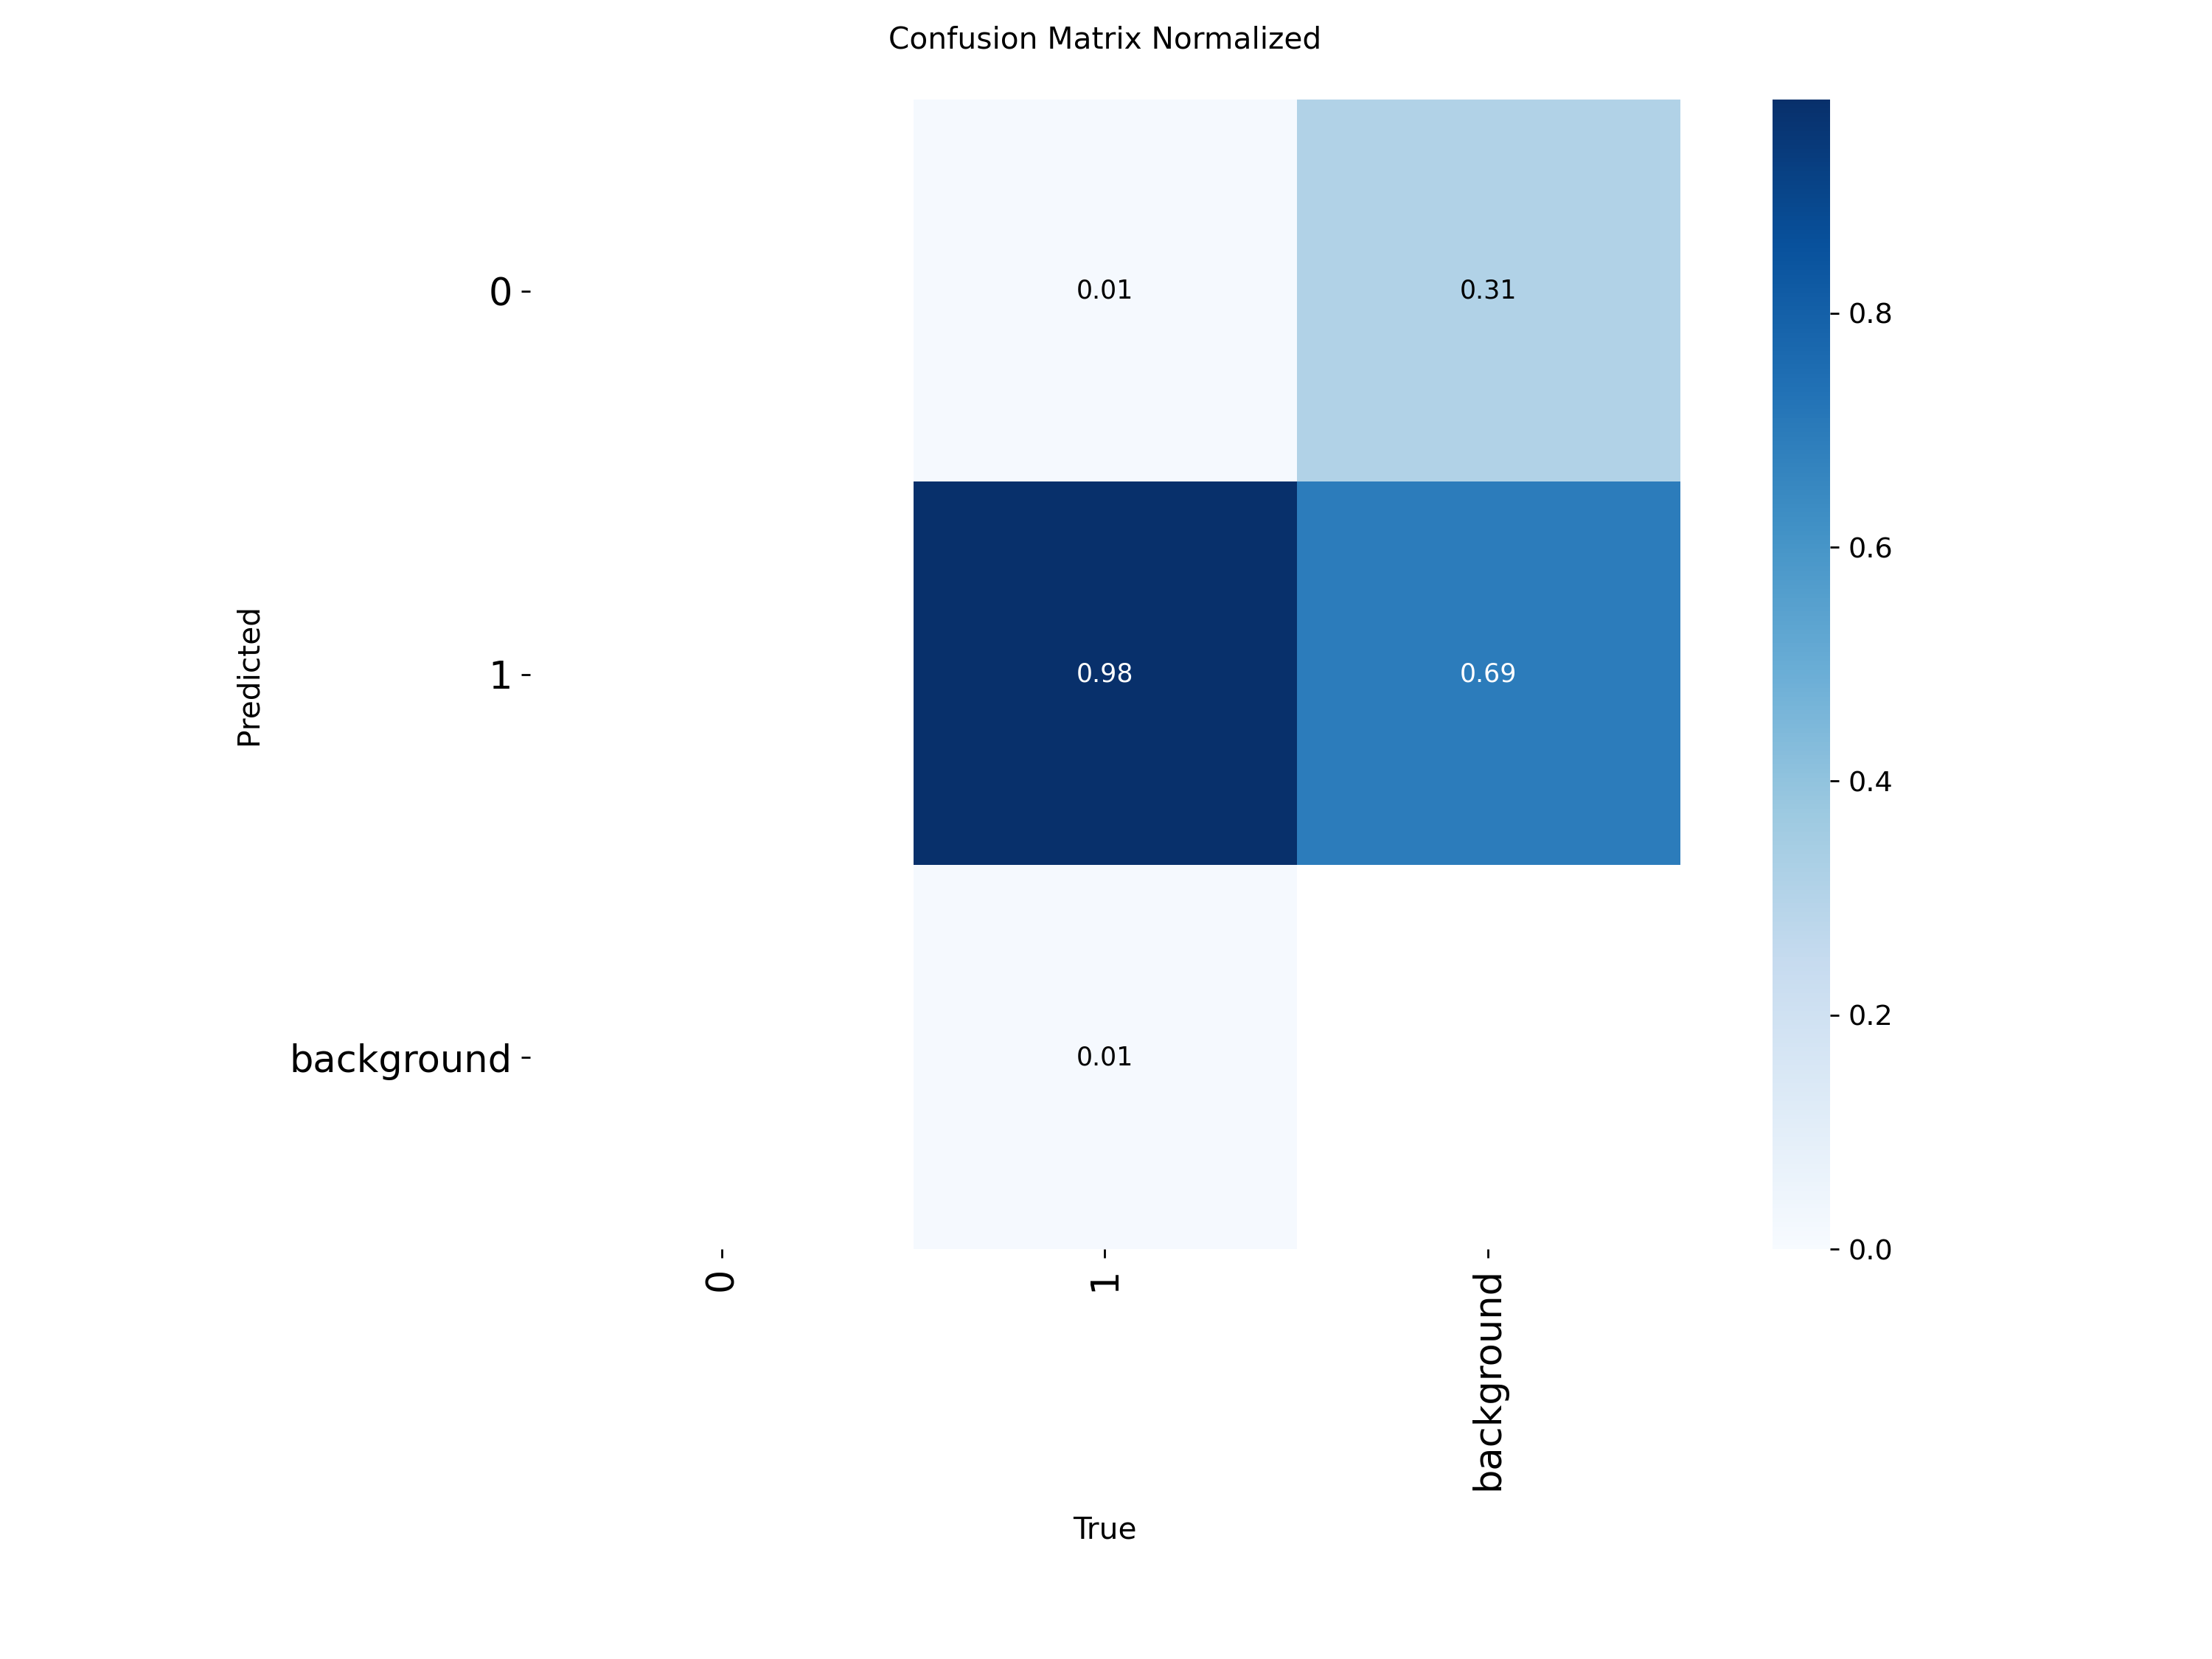

In [27]:
Image("runs/segment/val2/confusion_matrix_normalized.png")